In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생 변수 생성 함수
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # 기본 파생 변수
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    
    # 🌟🌟🌟 새로운 파생 변수 1개만 추가 🌟🌟🌟
    df_processed['bone_density_bmi_interaction'] = df_processed['bone_density'] * df_processed['BMI']

    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

# 중요도가 낮은 변수 리스트 (최고점 모델)
low_importance_features = [
    'sleep_pattern_sleep difficulty',
    'activity_moderate',
    'mean_working',
    'family_medical_history_unknown'
]
final_cols = [col for col in common_cols if col not in low_importance_features]

# 5. K-Fold 교차 검증을 통한 RMSE 측정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_oof = np.zeros(len(train_final))
xgb_oof = np.zeros(len(train_final))

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

print("--- 로컬 점수 측정 시작 ---")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    lgb_model = lgb.LGBMRegressor(
        random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40
    )
    lgb_model.fit(X_train, y_train)
    lgb_oof[val_index] = lgb_model.predict(X_val)

    xgb_model = xgb.XGBRegressor(
        random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_oof[val_index] = xgb_model.predict(X_val)

weight_lgb = 0.6
weight_xgb = 0.4
oof_predictions = (weight_lgb * lgb_oof) + (weight_xgb * xgb_oof)
oof_rmse = np.sqrt(mean_squared_error(y_train_full, oof_predictions))

print(f"**교차 검증 RMSE 예상 점수**: {oof_rmse:.5f}")
print("---")

# 6. 최종 모델 학습 및 제출 파일 생성
print("--- 최종 모델 학습 및 제출 파일 생성 시작 ---")

final_lgb_model = lgb.LGBMRegressor(
    random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40
)
final_lgb_model.fit(X_train_full, y_train_full)

final_xgb_model = xgb.XGBRegressor(
    random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1
)
final_xgb_model.fit(X_train_full, y_train_full)

# 테스트 데이터에 대한 예측
lgb_test_preds = final_lgb_model.predict(test_final[final_cols])
xgb_test_preds = final_xgb_model.predict(test_final[final_cols])

# 예측값 앙상블
final_predictions = (weight_lgb * lgb_test_preds) + (weight_xgb * xgb_test_preds)

# 제출 파일 생성
submission_df['stress_score'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

print("✅ submission.csv 파일 생성 완료!")
print("\n테스트 데이터 예측값 (상위 5개):\n", final_predictions[:5])

In [2]:
pip install lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 25
[LightGBM] [Info] Start training from score 0.482130


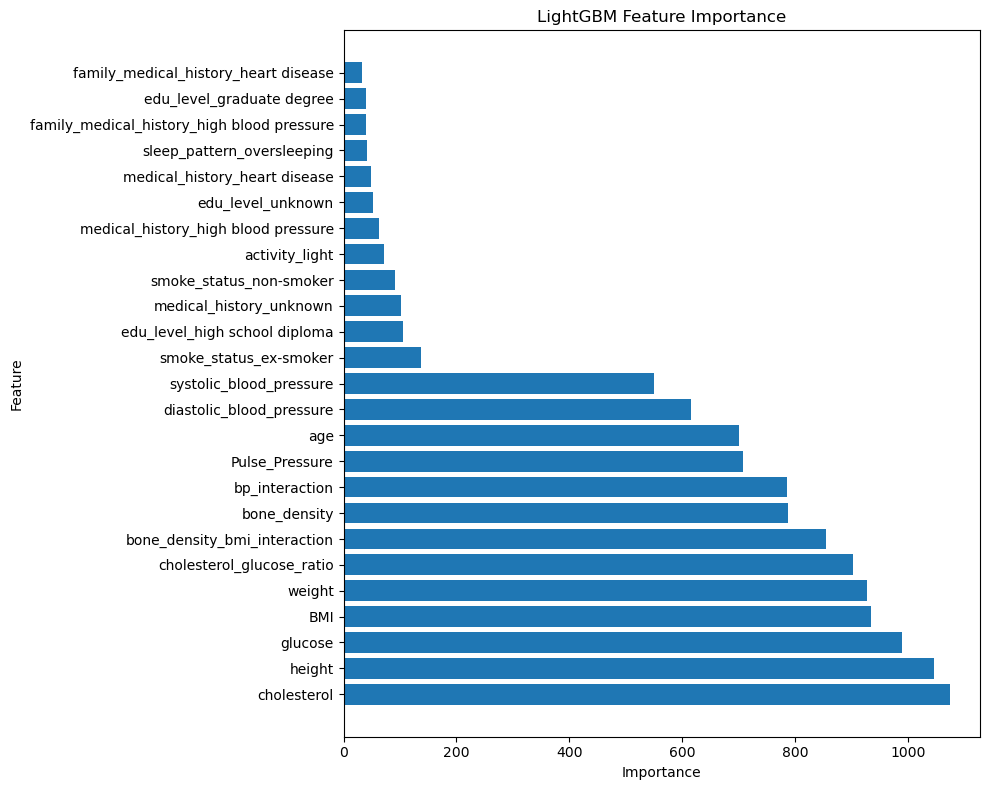

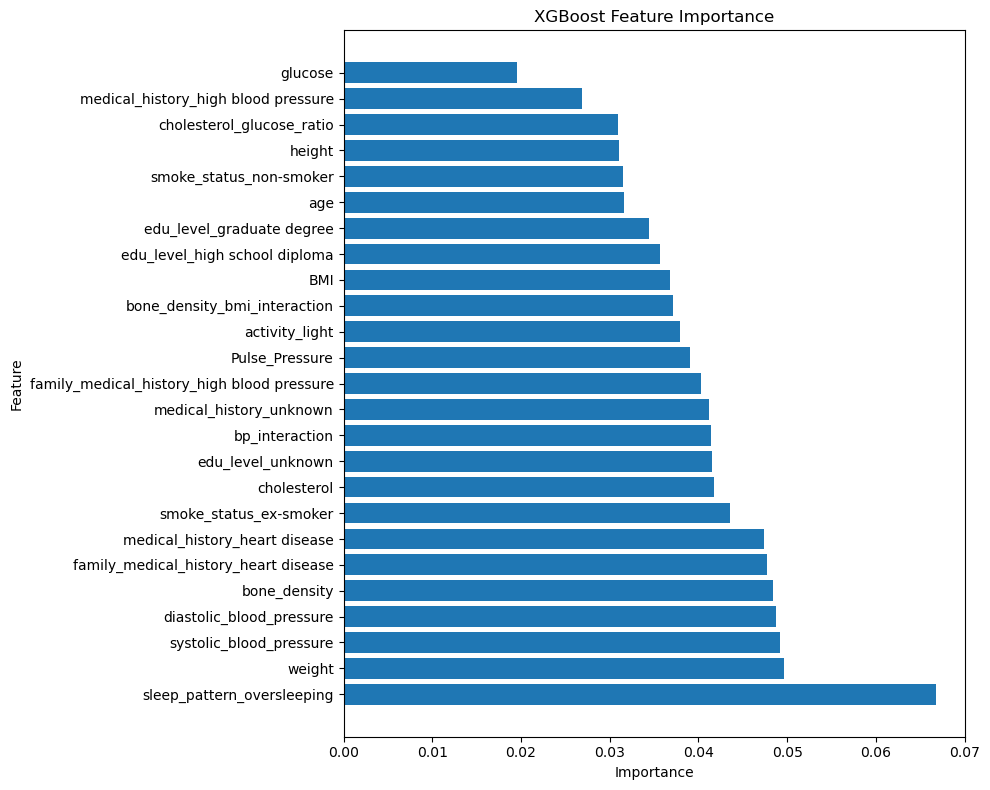

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

# 데이터 전처리 및 모델 학습 (네 코드 그대로)
# ... (생략) ...

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

final_lgb_model = lgb.LGBMRegressor(
    random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40
)
final_lgb_model.fit(X_train_full, y_train_full)

final_xgb_model = xgb.XGBRegressor(
    random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1
)
final_xgb_model.fit(X_train_full, y_train_full)

# 변수 중요도를 시각화하는 코드
def plot_feature_importance(importance, feature_names, title):
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# LightGBM 변수 중요도 시각화
plot_feature_importance(final_lgb_model.feature_importances_, final_cols, 'LightGBM Feature Importance')

# XGBoost 변수 중요도 시각화
plot_feature_importance(final_xgb_model.feature_importances_, final_cols, 'XGBoost Feature Importance')